# Prototypical Network on Ultrasound Images for COVID-19 Detection

There may be some discrepancies between code in this notebook and the scripts in /protonet. Please refer to the scripts for complete experiments, and use this notebook for initial testing.

## Import libraries
Python version 3.9.9 is used for this project. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
#Check GPU support, activate GPU if available
print(torch.cuda.is_available())

False


## Import data

The dataset is saved in: https://github.com/nrc-cnrc/COVID-US
4 classes of data is present: 
- COVID 
- Normal 
- Other 
- Penumonia 

Data is structured in class subfolders. i.e. 
train/
- COVID/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...
- Normal/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...
- Pneumonia/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...
- Other/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...
test/
- COVID/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...
- Normal/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...
- Pneumonia/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...
- Other/
    - [image-file-name-1].jpg
    - [image-file-name-2].jpg
    - ...

## Read data

Currently data is split randomly into:
- 90% for train set
- 10% for test set 

Dataset is augmented by rotating each image by 90, 180, 270 degrees. Resulting sets are 4 times the original. 
Only convex probe images are used. 

In [2]:
import defs 
def read_images(base_directory):
    """
    Reads all the images from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    # pool = mp.Pool()

    results = [pool.apply_async(defs.read_subdir_image,
                            args=(
                                base_directory + '/' + directory + '/', directory,)) for directory in os.listdir(base_directory) if not directory.startswith('.')]
    pool.close()

    for result in results:
        if datax is None:
            datax = result.get()[0]
            datay = result.get()[1]
        else:
            datax = np.vstack([datax, result.get()[0]])
            datay = np.concatenate([datay, result.get()[1]])
    return datax, datay

In [ ]:
# Get videos with certain LUS scores
import pandas as pd
df_LUS = pd.read_csv("LUSS_metadata.csv")
target_vids = df_LUS[(df_LUS['class']=='COVID') & (df_LUS['LUSS']==2)].id.tolist()
target_vids

In [ ]:
import defs_LUS
def read_images_with_score(base_directory, target_vids):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    if __name__ == "__main__":
        pool = mp.Pool(mp.cpu_count())

        results = [pool.apply_async(defs_LUS.read_subdir_image,
                                args=(
                                    base_directory + '/' + directory + '/', directory, target_vids)) for directory in os.listdir(base_directory) if not directory.startswith('.')]
        pool.close()

        for result in results:
            print(result.ready())
            if result.ready(): 
                if datax ==  None:
                    print(result.get()[0])
                    datax = result.get()[0]
                    # print("datax type is:" + type(datax))
                    datay = result.get()[1]
                else:
                    datax = np.vstack([datax, result.get()[0]])
                    datay = np.concatenate([datay, result.get()[1]])
    return datax, datay

In [3]:
%%time 
trainx, trainy = read_images('/directory_path_to_train_folder')

CPU times: user 19.8 ms, sys: 62.6 ms, total: 82.3 ms
Wall time: 2.82 s


In [4]:
%%time 
testx, testy = read_images('/directory_path_to_test_folder')

CPU times: user 11.3 ms, sys: 43.7 ms, total: 55 ms
Wall time: 1.49 s


In [6]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((160, 224, 224, 3), (160,), (64, 224, 224, 3), (64,))

## Create samples

In [5]:
def extract_sample(n_way, n_support, n_query, datax, datay, include_COVID):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  if include_COVID:
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    K = ["Normal","Other","Pneumonia","COVID"]
  else: 
    # if include_COVID is false, take out all COVID instances
    possible_choices = [cls for cls in datay if cls != "COVID"]
    K = np.random.choice(np.unique(possible_choices), n_way, replace=False)
    K = ["Normal","Other","Pneumonia"]
  sample = []
  sample_class = []
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    # print(sample_cls.shape)
    sample.append(sample_cls)
    sample_class.append(cls) # get real class names 
  sample = np.array(sample)
  # print(sample.shape)
  # print(type(sample))
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  
  return({
      'images': sample,
      'sample_class': sample_class, 
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [6]:
# version in remote (if input datax and datay are tensors)
def extract_sample(n_way, n_support, n_query, datax, datay, prob_type, include_COVID):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (torch.Tensor) dataset of images
      datay (torch.Tensor): dataset of labels 0-3
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  sample_class = []

  if prob_type == 2: 
    index_y = [[datay == 0], [datay == 3]] # [0] = negative labels, [1] = positive labels
  elif prob_type == 3: 
    index_y = [[datay == 0], [datay == 2], [datay==3]] # [0] = normal, [1] = Pneumonia, [2] = COVID
  else: # prob_type == 4
    if include_COVID:
      index_y = [[datay == 0], [datay == 1], [datay == 2], [datay==3]]
    else: 
      index_y = [[datay == 0], [datay == 1], [datay == 2]]
      prob_type = 3
  for i in range(0,prob_type): 
    datax_cls = datax[index_y[i]] 
    perm=datax_cls[torch.randperm(datax_cls.size()[0])]
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
    sample_class.append(i) # get real class nums
  
  sample_ten = torch.stack(sample)
  sample = sample_ten.permute(0,1,4,2,3).float()
  
  return({
      'images': sample,
      'sample_class': sample_class, 
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [7]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample and display it

*   n_way = 3
*   n_support = 5
*   n_query = 2

This example does not contain COVID data. 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0, 1]


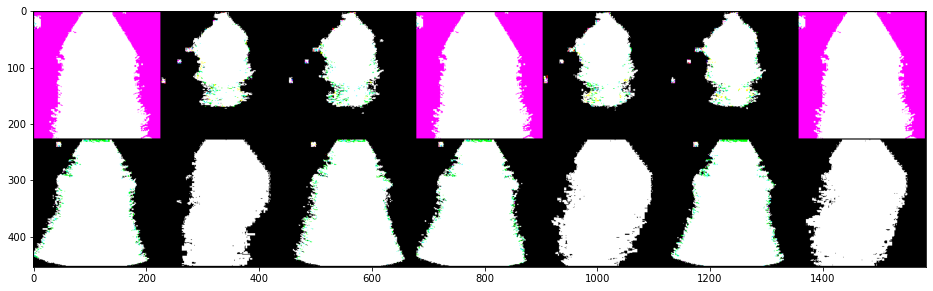

In [8]:
# Using extract_sample in remote (using tensors)
train_y_num = []
for y in trainy: 
    train_y_num.append(0 if y=="Normal" else 1 if y=="Other" else 2 if y=="Pneumonia" else 3)
# train_y_num = np.array(train_y_num)

local_batch = torch.tensor(np.asarray(trainx).astype(int))
local_labels=torch.tensor(np.asarray(train_y_num).astype(int))

sample_example = extract_sample(4, 5, 2, local_batch, local_labels, 2, include_COVID=False)
print(sample_example['sample_class'])
display_sample(sample_example['images'])

In [9]:
sample_example['images'].shape

torch.Size([2, 7, 3, 224, 224])

## Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

The embedding part takes a (224x224x3) image and returns a column vector of length 64. 

Model 0: The image2vector function is composed of 4 modules. Each module comprises a 64-filter 3 × 3 convolution, a batch normalization layer, a ReLU nonlinearity and a 2 × 2 max-pooling layer. 
Model 1: ResNet18

When applied to the 224 × 224 ultrasound images this architecture results in a 64-dimensional output space.

In [6]:
class Flatten(nn.Module):
  def __init__(self, encoder):
    super(Flatten, self).__init__()
    self.encoder = encoder

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(model_type, prob_type):
  """
  Loads the prototypical network model
  Arg: 
    model_type: 0-basic CNN, 1-ResNet18, 2-ResNet18 with trainable last 4 conv layers, 
                3-ResNet50, 4-ResNet50 with trainable last 3 conv layers, 
                5-VGG16 with trainable last 4 conv layers. 
    prob_type: 2,3,4 depending on total class number to classify. 
  Returns:
      Model (Class ProtoNet)
  """
  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2))

  if model_type==0: 
    x_dim=(3,224,224)
    hid_dim=64
    z_dim=64
    encoder = nn.Sequential(
      conv_block(x_dim[0], hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, hid_dim),
      conv_block(hid_dim, z_dim),
      Flatten()
    )
  
  elif model_type==1:
      encoder = models.resnet18(pretrained=True)
      num_ftrs = encoder.fc.in_features
      encoder.fc = nn.Linear(num_ftrs, prob_type) # reinitialize last layer to have out_feature, corresponding to num_class
      # Freeze all but last layer
      for name, param in encoder.named_parameters():
          if not 'fc' in name: 
              param.requires_grad = False
    
  elif model_type==2:
    encoder = models.resnet18(pretrained=True)
    num_ftrs = encoder.fc.in_features
    encoder.fc = nn.Linear(num_ftrs, prob_type) # reinitialize last layer to have out_feature, corresponding to num_class
    # Freeze all but last layer (4 conv layers) and fc 
    for name, param in encoder.named_parameters(): 
        if 'fc' in name or 'layer4' in name: 
            param.requires_grad = True
        else: 
            param.requires_grad = False
  
  elif model_type==3:
    encoder = models.resnet50(pretrained=True)
    num_ftrs = encoder.fc.in_features
    encoder.fc = nn.Linear(num_ftrs, prob_type) # reinitialize last layer to have out_feature, corresponding to num_class
    # Freeze all but last layer
    for name, param in encoder.named_parameters():
        if not 'fc' in name: 
            param.requires_grad = False
    
  elif model_type==4:
    encoder = models.resnet50(pretrained=True)
    num_ftrs = encoder.fc.in_features
    encoder.fc = nn.Linear(num_ftrs, prob_type) # reinitialize last layer to have out_feature, corresponding to num_class
    # Freeze all but last layer 4.2 with 3 conv layers 
    for name, param in encoder.named_parameters(): 
        if 'fc' in name or 'layer4.2' in name: 
            param.requires_grad = True
        else: 
            param.requires_grad = False

  elif model_type==5: 
    encoder = models.vgg16(pretrained=True)
    num_ftrs = encoder.classifier[-1].in_features
    encoder.classifier[-1] = nn.Linear(num_ftrs, prob_type)
    # freeze all but the last 4 conv layers past [20]
    for name, param in encoder.features[:20].named_parameters(): 
        param.requires_grad = False
  
  return ProtoNet(encoder)

In [11]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [12]:
from sklearn import metrics
import torchvision.models as models  

class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
    encoder : CNN encoding the images in sample
    n_way (int): number of classes in a classification task
    n_support (int): number of labeled examples per class in the support set
    n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy, precision and recall and output for classification task
    Args:
      sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
      torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images']
    sample_class = sample['sample_class']

    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
    
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                  x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)

    z = self.encoder.forward(x)
    z_dim = z.size(-1) 

    #create class prototype 
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)

    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)

    # compute metrics
    y_true_np = target_inds.squeeze().cpu().detach().numpy().flatten()
    y_pred_np = y_hat.cpu().detach().numpy().flatten() 

    accuracy = metrics.accuracy_score(y_true_np, y_pred_np)
    cls_labels = np.arange(0, n_way, 1, dtype=int)

    precision = metrics.precision_score(y_true_np, y_pred_np, average=None, zero_division=1, labels=cls_labels)
    recall = metrics.recall_score(y_true_np, y_pred_np, average=None, zero_division=1, labels=cls_labels)

    return loss_val, {
      'loss': loss_val.item(),
      'x_query': x_query, 
      'sample_class': sample_class, 
      'y_true_np': y_true_np, 
      'y_pred_np': y_pred_np, 
      'accuracy': accuracy, 
      'recall': recall,
      'precision': precision,
      'possibility': log_p_y
      }

## Train

In [13]:
from tqdm.notebook import tnrange

def train(model, optimizer, prob_type, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc_sklearn = 0
    running_precision = 0.0
    running_recall = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      # training without covid data if n_way <= 3 
      if n_way <= 3: 
        sample = extract_sample(n_way, n_support, n_query, train_x, train_y, prob_type, include_COVID=False)
      else: 
        sample = extract_sample(n_way, n_support, n_query, train_x, train_y, prob_type, include_COVID=True)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)

      running_loss += output['loss']
      running_acc_sklearn += output['accuracy']
      running_precision += output['precision']
      running_recall += output['recall']

      loss.backward()
      optimizer.step()
    
    epoch_loss = running_loss / epoch_size
    epoch_acc_sklearn = running_acc_sklearn / epoch_size
    epoch_precision = running_precision / epoch_size
    epoch_recall = running_recall / epoch_size

    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc_sklearn))
    for i in range(0, len(epoch_precision)): 
      print('class {:d} -- Precision: {:.4f} Recall: {:.4f}'.format(i, epoch_precision[i], epoch_recall[i]))

    epoch += 1
    scheduler.step()

In [2]:
%%time

model = load_protonet_conv(1, 4)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 2
n_support = 5 
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 1
epoch_size = 10

train(model, optimizer, 2, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


## Test

In [15]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  for episode in tnrange(test_episode):
    with torch.no_grad(): 
      sample = extract_sample(n_way, n_support, n_query, test_x, test_y, include_COVID=True)
      loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_accuracy += output['accuracy']
    running_precision += output['precision']
    running_recall += output['recall']

  avg_loss = running_loss / test_episode
  avg_acc = running_accuracy / test_episode
  avg_precision = running_precision / test_episode
  avg_recall = running_recall / test_episode

  print('-- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))
  for i in range(0, len(avg_precision)): 
    print('class {:d} -- Precision: {:.4f} Recall: {:.4f}'.format(i, avg_precision[i], avg_recall[i]))


In [16]:
n_way = 4
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 200

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

# GradCam Analysis 
- check interpretability of the model (last conv layer)

In [2]:
from torchvision.models import resnet50 
from torchvision.models import vgg16
encoder_50 = resnet50(pretrained=True)
encoder_vgg16 = vgg16(pretrained=True)

In [17]:
model = load_protonet_conv(1) #change fc = 2 or 4
model.load_state_dict(torch.load('./models_LUSS_cropped/resnet18.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [18]:
# define sets of images for grad-cam testing. 
gradcamx, gradcamy = read_images('path_to_directory/explain_test')
croppedx, croppedy = read_images('path_to_directory/cropped_explain_test')

In [19]:
train_y_num = []
for y in gradcamy: 
    train_y_num.append(0 if y=="Normal" else 1 if y=="Other" else 2 if y=="Pneumonia" else 3)

gradcam_x = torch.tensor(np.asarray(gradcamx).astype(int))
gradcam_y=torch.tensor(np.asarray(train_y_num).astype(int))

In [20]:
train_y_num = []
for y in croppedy: 
    train_y_num.append(0 if y=="Normal" else 1 if y=="Other" else 2 if y=="Pneumonia" else 3)
cropped_x = torch.tensor(np.asarray(croppedx).astype(int))
cropped_y=torch.tensor(np.asarray(train_y_num).astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0, 1]


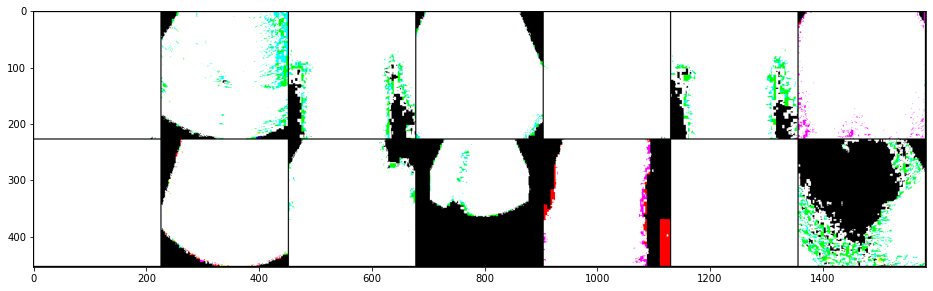

In [21]:
sample_example = extract_sample(2, 5, 2, cropped_x, cropped_y, 2, include_COVID=True)
print(sample_example['sample_class'])
display_sample(sample_example['images'])

In [22]:
# produce true positives, true negatives, false positives and false negatives
def test_gradcam(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  target_index = 1 ###### CHANGE FOR BINARY VS 4 CLASSES to 1 in binary######

  opposing_target_index = 0 

  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  
  true_pos = 0
  true_neg = 0
  false_pos = 0
  false_neg = 0
  true_pos_possibility = 0
  true_neg_possibility = 0 
  
  for episode in tnrange(test_episode):
    with torch.no_grad(): 
      sample = extract_sample(n_way, n_support, n_query, test_x, test_y, 2, include_COVID=True)
      loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_accuracy += output['accuracy']
    running_precision += output['precision']
    running_recall += output['recall']

    possibility = output['possibility']
    y_true = output['y_true_np']
    y_pred = output['y_pred_np']
    query_samples = output['x_query']
    
    # get true positives and their associated predicted possibilities
    if y_true[target_index] == y_pred[target_index]: 
      if type(true_pos) == int and type(true_pos_possibility) == int: 
        true_pos = query_samples[target_index]
        true_pos_possibility = possibility[target_index]
      else: 
        true_pos = torch.cat((true_pos, query_samples[target_index]), dim=0)
        true_pos_possibility = torch.cat((true_pos_possibility, possibility[target_index]), dim=0)
    
    if y_true[opposing_target_index] == y_pred[opposing_target_index]: 
      if type(true_neg) == int:
        true_neg = query_samples[opposing_target_index]
        true_neg_possibility = possibility[opposing_target_index]
      else: 
        true_neg = torch.cat((true_neg, query_samples[opposing_target_index]), dim=0)
        true_neg_possibility = torch.cat((true_neg_possibility, possibility[opposing_target_index]), dim=0)
    
    # get falses
    # for i,pred in enumerate(y_pred): 
    # false positives: take a normal image as a COVID image
    if y_pred[opposing_target_index] == target_index: 
      if type(false_pos) == int:
        false_pos = query_samples[opposing_target_index]
      else: 
        false_pos = torch.cat((false_pos, query_samples[opposing_target_index]), dim=0)
    # false negatives: take a COVID image as normal
    elif y_pred[target_index] == opposing_target_index: 
      if type(false_neg) == int:
        false_neg = query_samples[target_index]
      else: 
        false_neg = torch.cat((false_neg, query_samples[target_index]), dim=0)

  avg_loss = running_loss / test_episode
  avg_acc = running_accuracy / test_episode
  avg_precision = running_precision / test_episode
  avg_recall = running_recall / test_episode

  print(true_pos.shape) if type(true_pos) != int else print("true_pos == 0")
  print(true_neg.shape) if type(true_neg) != int else print("true_neg == 0")
  print(false_pos.shape) if type(false_pos) != int else print("false_pos == 0")
  print(false_neg.shape) if type(false_neg) != int else print("false_neg == 0")

  print('-- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))
  for i in range(0, len(avg_precision)): 
    print('class {:d} -- Precision: {:.4f} Recall: {:.4f}'.format(i, avg_precision[i], avg_recall[i]))

  return true_pos, true_pos_possibility, true_neg, true_neg_possibility, false_pos, false_neg

In [23]:
n_support = 5
n_query = 1
n_way = 2
episode = 200

true_pos, true_pos_possibility, true_neg, true_neg_possibility, false_pos, false_neg = test_gradcam(model, cropped_x, cropped_y, n_way, n_support, n_query, episode)

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([171, 3, 224, 224])
torch.Size([173, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([24, 3, 224, 224])
-- Loss: 0.4257 Acc: 0.8600
class 0 -- Precision: 0.9150 Recall: 0.8650
class 1 -- Precision: 0.9200 Recall: 0.8550


In [8]:
from pytorch_grad_cam import GradCAM 
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18

def get_visualization_gradcam(model, input, index):
    # model = resnet18(pretrained=True)
    target_layers = [model.layer4[-1]]
    input_tensor = input / 255
    rgb_img = input_tensor[index].permute(1,2,0).cpu().detach().numpy()

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[index, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    return visualization

In [9]:
encoder_18 = resnet18(pretrained=True)

# get all in false_neg and false_pos 
def get_images(encoder, image_array, array_type):
    for i in range(0, image_array.shape[0]): 
        visualization = get_visualization_gradcam(encoder, image_array, i)
        cam_image = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)
        cam_path = f'path_to_save_images/{array_type}_{i}.jpg'
        cv2.imwrite(cam_path, cam_image)

        orig = image_array[i].permute(1,2,0).cpu().detach().numpy()
        orig_image = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)
        orig_path = f'path_to_save_images/{array_type}_{i}.jpg'
        cv2.imwrite(orig_path, orig_image)
    print(image_array.shape[0])

In [149]:
get_images(encoder_18, false_pos, "false_pos") 

9


In [150]:
get_images(encoder_18, false_neg, "false_neg")

10


In [26]:
## for true_neg and true_pos, select some with high possibility (e^true_pos_possibility to get percentage confidence)
pos = torch.exp(true_pos_possibility[:,1])  ###### NEED TO CHANGE FOR BINARY VS 4 CLASSES ######
high_true_pos = pos>0.9999
selected_true_pos = true_pos[high_true_pos, :,:,:]
selected_true_pos.shape

torch.Size([72, 3, 224, 224])

In [27]:
get_images(encoder_18, selected_true_pos, "selected_true_pos")

72


In [146]:
pos = torch.exp(true_neg_possibility[:,0])
high_true_neg = pos>0.99999997

selected_true_neg = true_neg[high_true_neg, :,:,:]
selected_true_neg.shape

torch.Size([77, 3, 224, 224])

In [147]:
get_images(encoder_18, selected_true_neg[:20,:,:,:], "selected_true_neg")

20
